Implementing a basic DE solver for the neutrino winds in terms of psi

Runge-Kutta method from Wikipedia:
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/25f03454fd25957cc63be11ec534efdce349c52f">
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/95bdbb2e3aa83735085c0aadd577162c69e4056a">
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/81398071e8f180ac143bfdf4598ff47bf79eb689">
I use $\psi$ in place of t, and {r,v} as y. I calculate separate k values for r and v to get y'={r',v'}

Questions/next steps:

Issue with RK method

Use scipy integrator to find solutions?
Use absolute value of f1,f2 and minimize the distance between their zeros as a function of v0

The RK method works for a dt of .01 when I integrate out to t=1.5 and gives solutions as expected. Integrating farther does not seem to work unless I take the absolute value of f1 and f2, which does give me the expected solutions.
The adaptive RK method has issues when one of the coordinates is less than zero. I suspect that checking for the sign of x and inverting the dt change for x<0 may help

The adaptive method breaks down for x<0. The velocity is positive and increasing, but the x is rapidly getting more negative. The change in the exponential of x is negligible, but the change in x itself gets larger and larger, driving dt to 0 and causing infinite looping. I can't just use the percent change of the exponential of (x,u) because u is still increasing and 

In [78]:
import numpy as np
import matplotlib.pyplot as plt
np.seterr(all='raise')

cs=1
M=10
G=1
mB=1
dPdS=1
Se=0
rho=1
T=1
r0=1

def ndf1(psi,coords):
    try:
        return 1-np.exp(2*coords[1])
    except:
        print("Error in ndf1 at ",psi,", ",coords)
        return 0

def ndf2(psi,coords):
    return np.exp(-coords[0])*G*M/((cs**2)*r0)-2

def CoupledRungeKuttaStep(af1,af2,fn,t,dt): #takes state f(n) and steps to f(n+dt) using arbitrary input functions f1 and f2
    f1k1=dt*af1(t,fn)
    f2k1=dt*af2(t,fn)
    f1k2=dt*af1(t+dt/2,fn+np.array([f1k1/2,f2k1/2]))
    f2k2=dt*af2(t+dt/2,fn+np.array([f1k1/2,f2k1/2]))
    f1k3=dt*af1(t+dt/2,fn+np.array([f1k2/2,f2k2/2]))
    f2k3=dt*af2(t+dt/2,fn+np.array([f1k2/2,f2k2/2]))
    f1k4=dt*af1(t+dt,fn+np.array([f1k3,f2k3]))
    f2k4=dt*af2(t+dt,fn+np.array([f1k3,f2k3]))
    return np.array([t+dt,np.array([fn[0]+(f1k1+2*f1k2+2*f1k3+f1k4)/6,fn[1]+(f2k1+2*f2k2+2*f2k3+f2k4)/6])])

def percentChange(curr,step):
    return 100*abs(np.linalg.norm((step-curr)/np.linalg.norm(curr)))

def generateFuncNA(x0,u0,tmax):
    xsol=np.array([x0])
    usol=np.array([u0])
    tarray=np.array([0])
    t=0
    dt=.01
    ddt=1.5
    i=0
    prevstate=0
    currState=np.array([xsol[-1],usol[-1]])
    while t<tmax and abs(ndf1(t,currState))>.001 and ndf2(t,currState)>.001:
        
        #Load the current position of the system to determine if adaptation is necessary
        currState=np.array([xsol[-1],usol[-1]])
        
        #Calculate the next integration step using the RK function defined above
        step=CoupledRungeKuttaStep(ndf1,ndf2,currState,t,dt)
        
        #Limited adaptivity for RK. My attempt to implement full adaptivity were thwarted by the behavior of this system
        try: 
            pc = percentChange(currState,step[1])
        except:
            #print("Error at %change, currState: ",currState," step: ",step)
            pc=10
        
        if pc>1:
            if currState[0]>0:
                dt=dt/2
            else:
                dt=dt*2
        elif pc<.1:
            dt = dt*2
        
        xsol=np.append(xsol,step[1][0])
        usol=np.append(usol,step[1][1])
        t=t+dt
        tarray=np.append(tarray,t)
        i=i+1
    #print("*********Iteration complete***********, exit conditions t=",t,", exp(x)=",np.exp(currState[0]))
    return np.array((tarray,xsol,usol))

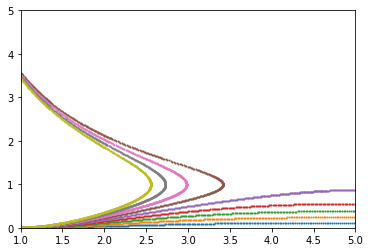

In [79]:
plt.figure(3)
plt.xlim(1,5)
plt.ylim(0,5)

it=1
for i in np.arange(.001,.01,.001):
    #print("\n*******iteration********* ",i,"\n")
    func=generateFuncNA(0,np.log(i),5)
    plt.scatter(np.exp(func[1]),np.exp(func[2]),s=1);

In [7]:
print(100*abs(np.linalg.norm((np.array([-0.46618877,1.57632707])-np.array([-0.45231597,1.56768413]))/np.linalg.norm(np.array([-0.45231597,1.56768413])))))

1.0017501338956245


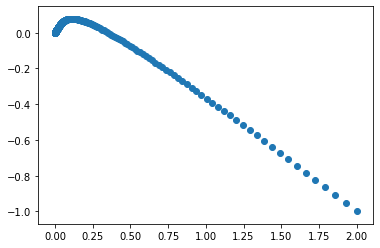

In [11]:
#Testing the CoupledRungeKuttaStep function with a known DE
#It works as expected

def testf(t,x):
    return -3*x[0]+np.sqrt(2)*x[1]
def testf2(t,x):
    return np.sqrt(2)*x[0]-2*x[1]

def generateTestFunc(x0,y0):
    x1=np.array([x0])
    x2=np.array([y0])
    t=0
    while t<10:
        step=CoupledRungeKuttaStep(testf,testf2,np.array([x1[-1],x2[-1]]),t,.01)
        x1=np.append(x1,step[1][0])
        x2=np.append(x2,step[1][1])
        t=t+.01
        #print(xstep)
    return np.array([x1,x2])

func2=generateTestFunc(2,-1)
plt.scatter(func2[0],func2[1])

In [48]:
import scipy.integrate as sc

def ndf1(psi,coords):
    return 1-np.exp(2*coords[1])

def ndf2(psi,coords):
    return np.exp(-coords[0])*G*M/((cs**2)*r0)-2

lambda t,y: (ndf1(t,y),ndf2(t,y))

sol=sc.solve_ivp(lambda t,y: (ndf1(t,y),ndf2(t,y)),(0,np.log(5)),(0,np.log(.001)))

In [49]:
sol['t']

array([0.00000000e+00, 9.99855586e-04, 1.09984114e-02, 1.10983970e-01,
       1.11083956e+00, 1.60943791e+00])

In [50]:
sol['y']

array([[ 0.00000000e+00,  9.99854578e-04,  1.09983994e-02,
         1.10983680e-01,  1.10891765e+00,  1.60151079e+00],
       [-6.90775528e+00, -6.89976143e+00, -6.82037060e+00,
        -6.07925406e+00, -2.42083165e+00, -2.11951257e+00]])

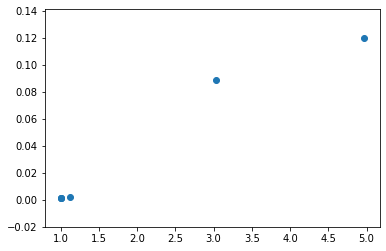

In [51]:
plt.scatter(np.exp(sol['y'][0]),np.exp(sol['y'][1]))

In [87]:
#Attempt at fully adaptive RK method. I had to implement exit conditions based on the x values to prevent infinite looping, 
#and one solution curve does not integrate very far in the x direction
#I think I have it working now

def percentChange2(curr,step):
    if curr[0]<0:
        curr2=np.array([np.exp(curr[0]),curr[1]])
        step2=np.array([np.exp(step[0]),step[1]])
        return 100*abs(np.linalg.norm((step2-curr2)/np.linalg.norm(curr2)))
    else:
        return 100*abs(np.linalg.norm((step-curr)/np.linalg.norm(curr)))

def generateFunc(x0,u0,itermax):
    xsol=np.array([x0])
    usol=np.array([u0])
    tarray=np.array([0])
    t=0
    dt=.01
    ddt=1.5
    i=0
    prevstate=0
    currState=np.array([xsol[-1],usol[-1]])
    while np.exp(currState[0])>1e-6 and np.exp(currState[0])<5: #and abs(ndf1(t,currState))>.001 and ndf2(t,currState)>.001:
        
        #Load the current position of the system to determine if adaptation is necessary
        currState=np.array([xsol[-1],usol[-1]])
        
        #Calculate the next integration step using the RK function defined above
        step=CoupledRungeKuttaStep(ndf1,ndf2,currState,t,dt)
        
        #Calculate percent change from current state to predicted next state
        try:
            pc=percentChange2(currState,step[1])
        except:
            print("Error at %change, currState: ",currState," step: ",step)
            break
                
        #Adapt dt to ensure the change in (x,u) is between .1 and 1 percent
        #This particular system has an issue where if x<0, decreasing dt increases the change in (x,u)
        #If x<0, we increase dt rather than decreasing it to account for this peculiarity
        #I have not observed any similar issues when dt is too small
        
        if pc>1:
            #print("%change too big, currState=",currState,", dt=",dt,", step=",np.array(step[1]),", \n%change = ",pc,"\n")
            pc2=1e10
            prevpc2=1e10
            while pc2>1:
                dt=dt*ddt
                step2=CoupledRungeKuttaStep(ndf1,ndf2,currState,t,dt)
                pc2=percentChange2(currState,step2[1])
                if pc2>prevpc2:
                    ddt=1/ddt
                dt=ddt*dt
                prevpc2=pc2
                #print("dt=",dt,", step=",step2[1],"%=",pc2)
            step=step2
            #if step[1][0]>0: 
            #    dt=.5*dt
            #else: 
            #    dt=1.5*dt
            #print("new dt: ",dt)
        elif pc<.1: 
            #print("%change too small, currState=",currState,", dt=",dt,", step=",np.array(step[1]),", \n%change = ",pc,"\n")
            pc2=1e-10
            prevpc2=1e-10
            while pc2<.1:
                dt=dt*ddt
                step2=CoupledRungeKuttaStep(ndf1,ndf2,currState,t,dt)
                pc2=percentChange2(currState,step2[1])
                if pc2<prevpc2:
                    ddt=1/ddt
                dt=ddt*dt
                prevpc2=pc2
                #print("dt=",dt,", step=",step2[1],"%=",pc2)
            step=step2
            
            #if step[1][0]>0:
            #    dt=1.5*dt
            #else:
            #    dt=.5*dt
            #print("new dt: ",dt)
               
        xsol=np.append(xsol,step[1][0])
        usol=np.append(usol,step[1][1])
        t=t+dt
        tarray=np.append(tarray,t)
        i=i+1
    #print("*********Iteration complete***********, exit conditions t=",t,", exp(x)=",np.exp(currState[0]))
    return np.array((tarray,xsol,usol))

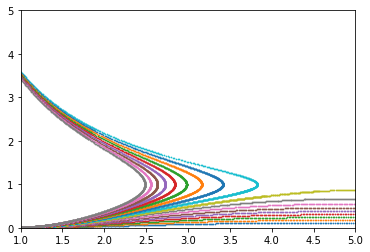

In [92]:
#func=generateFunc(0,np.log(.001),1.5)
#plt.figure(1)
#plt.scatter(func[0],func[1],s=1)
#plt.figure(2)
#plt.scatter(func[0],func[2],s=1)
plt.figure(3)
plt.xlim(1,5)
plt.ylim(0,5)
#plt.scatter(np.exp(func[1]),np.exp(func[2]),s=1);

it=1
for i in np.arange(.001,.01,.0005):
    #print("\n*******iteration********* ",i,"\n")
    func=generateFunc(0,np.log(i),50)
    plt.scatter(np.exp(func[1]),np.exp(func[2]),s=.5);